In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import zipfile

In [36]:
local_zip = 'data/archive.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
base_dir = 'data/sortify'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)

In [25]:
def get_dataset_path(base_dir):
    classes = sorted(os.listdir(base_dir))
    file_paths, labels = [], []
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        file_paths.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        labels.extend([idx] * len(os.listdir(class_dir)))
    return file_paths, labels, classes

In [26]:
file_paths, labels, class_names = get_dataset_path(base_dir)
print(f"Found {len(file_paths)} images across {len(class_names)} classes.")

Found 9541 images across 6 classes.


In [27]:
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(test_paths, test_labels, test_size=0.5, stratify=test_labels, random_state=42)

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(base_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(base_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 9541 images belonging to 6 classes.
Found 9541 images belonging to 6 classes.


In [29]:
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [30]:
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 164742 (643.52 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [31]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_model_classification.keras", save_best_only=True)
]

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
298/298 [==============================] - 140s 464ms/step - loss: 0.7572 - accuracy: 0.7228 - val_loss: 0.4558 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 2/20
298/298 [==============================] - 138s 463ms/step - loss: 0.5527 - accuracy: 0.7995 - val_loss: 0.3916 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 3/20
298/298 [==============================] - 138s 464ms/step - loss: 0.4716 - accuracy: 0.8321 - val_loss: 0.3466 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/20
298/298 [==============================] - 145s 488ms/step - loss: 0.4171 - accuracy: 0.8507 - val_loss: 0.2958 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 5/20
298/298 [==============================] - 139s 465ms/step - loss: 0.3840 - accuracy: 0.8639 - val_loss: 0.3031 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 6/20
298/298 [==============================] - 139s 465ms/step - loss: 0.3530 - accuracy: 0.8746 - val_loss: 0.2595 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 7/20
298/298 [==========================

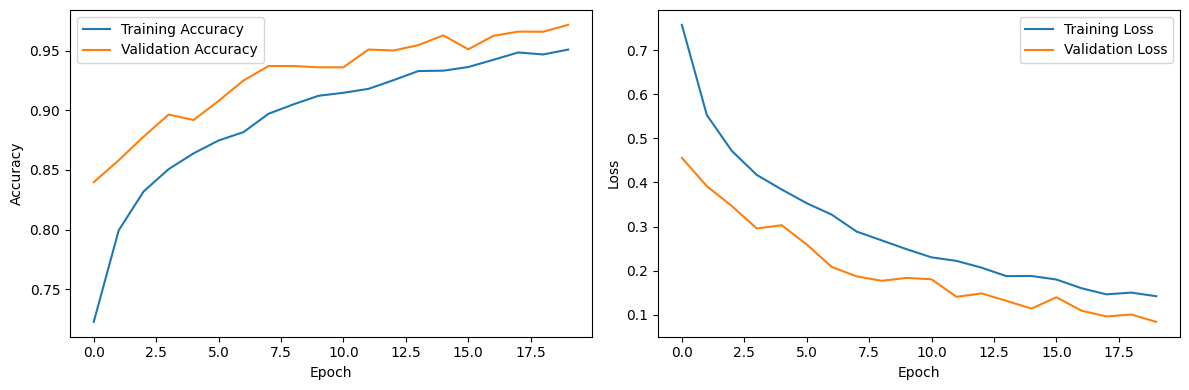

In [34]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
model.save('best_model_classification.keras')